In [2]:
import pandas as pd
import numpy as np
from glob import glob 
from os.path import join
import ntpath
import os
from collections import defaultdict
import math
import matplotlib.pyplot as plt
from  utils import matplotlib_setup, extract_sampler_names


%matplotlib inline

In [3]:
patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]
markers = ['>','*','<','o','^']
LINEWIDTH = 12
MSIZE = 40
MEDGESIZE = 12
YLABEL = '#mean Avg Records \n\
inrease Rate (against unlimited Cache)'

K=1
FILTERED=False
INCREASE_RATE_MET = 'mean'
filtered_attacks = ['Infiltration']

fold_exp = '{}fold_{}.csv'.format(K) if K==10 else 'fold_{}.csv'

In [4]:
def get_sampling_dirs(a_dir, only=''):
    dirs= [os.path.join(a_dir, name) for name in os.listdir(a_dir) 
                if os.path.isdir(os.path.join(a_dir, name)) and name.endswith('_l')  ]
    return sorted(dirs)

def replace_w_fc100(d):
        start = d.find('CSVs_r')
        end = d.find('_m_')
        tobe_replaced = d[start:end]
        
        d = d.replace(tobe_replaced,'CSVs_r_1.0')
        return d

In [5]:
def get_increase_rate(d):
    if INCREASE_RATE_MET=='mean':
        return get_increse_rate_mean(d)
    elif INCREASE_RATE_MET == 'mean_avg':
        return get_increase_rate_mean_avg(d)

In [6]:
if FILTERED:
    OUTFILE = 'K_{}_RIR_filtered_{}.png'.format(K, INCREASE_RATE_MET) 
else:
    OUTFILE = 'K_{}_RIR_{}.png'.format(K, INCREASE_RATE_MET)

xtick_labels = ['100%','10%','1%','0.1%']
xtick_indices = np.arange(len(xtick_labels))

In [7]:

def read_folds(dataroot):
    return pd.concat([pd.read_csv(join(dataroot,fold_exp.format(i)), usecols=['Flow ID', 'Label'])\
                       for i in range(K)], sort=False)


In [12]:
def get_record_counts(df):
    record_counts = {}
    for l in df.Label.unique():
        df_i = df[df['Label']==l]
        grouped = df_i.groupby(['Flow ID'], sort=True) 
        record_counts[l]=grouped.size()
    return record_counts

df = pd.read_csv('/data/juma/data/ids18/categories/ordered_list.csv', names=['Label'])
if FILTERED:
    df = df[(~df['Label'].isin(filtered_attacks))]
ordered_labels = df['Label'].values

def get_increase_rate_mean_avg(d): # mean of each category
    gt_df = read_folds(replace_w_fc100(d))
    gt_record_counts = get_record_counts(gt_df)
    N = len(ordered_labels)
    
    csv_gt = 'CSVs_r_1.0_m_1.0'
    mean_avg_per_FC = {}
    mean_avg_per_FC[csv_gt]=np.ones((N,))

    csv_dirs = ['CSVs_r_0.1_m_1.0', 'CSVs_r_0.01_m_1.0', 'CSVs_r_0.001_m_1.0']
        
    for csv_dir in csv_dirs:
        df = read_folds(d.replace(csv_gt, csv_dir))
        record_counts = get_record_counts(df)
        increase_rate = {}
        
        means = []

        for l in ordered_labels:
            if l in gt_record_counts.keys():
                means.append((record_counts[l]/gt_record_counts[l]).mean())
            else:
                means.append(1)
        mean_avg_per_FC[csv_dir]=means
    return mean_avg_per_FC, ordered_labels

In [9]:
# set width of bar
barWidth = 0.144
def plot_bars(ax, bars, ylabel='Record Increase \n Rate (%) (log scale)',xlabel=None , show_legend=False):
    N = len(ordered_labels)
    assert N==len(bars['CSVs_r_1.0_m_1.0']), "#Categories and #bars do not match: {} vs {}"\
    .format(N, len(bars['CSVs_r_1.0_m_1.0']))
    
    # Set position of bar on X axis
    r1 = np.arange(N)
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
        
    # Make the plot
    ax.grid(linewidth=3,axis='y', color='grey')
    ax.bar(r1, bars['CSVs_r_1.0_m_1.0'], width=barWidth, color='r', edgecolor='white', label='Flow Cache Size: Ideal (100%)',\
            hatch=patterns[0])
    ax.bar(r2, bars['CSVs_r_0.1_m_1.0'], width=barWidth,color='b', edgecolor='white', label='Flow Cache Size: Ideal (10%)',\
            hatch=patterns[1])
    ax.bar(r3, bars['CSVs_r_0.01_m_1.0'], width=barWidth, color='y', edgecolor='white', label='Flow Cache Size: Ideal (1%)',\
            hatch=patterns[2])
    ax.bar(r4, bars['CSVs_r_0.001_m_1.0'], width=barWidth,color='g', edgecolor='white', label='Flow Cache Size: Ideal (0.1%)',\
            hatch=patterns[3])
    
    if show_legend:
        ax.legend(ncol=4,fancybox=True, framealpha=0.3, bbox_to_anchor=(0.5, 1.05),loc='upper center')
    ax.set_ylabel(ylabel)
    ax.set_ylim([1,10**3.3])
    ax.set_yscale('log')
    return ax

In [16]:
csv_dirs = ['CSVs_r_1.0_m_1.0', 'CSVs_r_0.1_m_1.0', 'CSVs_r_0.01_m_1.0', 'CSVs_r_0.001_m_1.0']
def draw_figure(root):
    global ordered_labels
    #drawing
    matplotlib_setup()
    
    fig, axes = plt.subplots(nrows=4,ncols=1,sharex=True,figsize=(60,24))
    plt.xticks([r + barWidth for r in range(len(ordered_labels))] ,ordered_labels,rotation=30)
    for i,sampler_dir in enumerate(sorted(glob(join(root,'*_l')))):
        results, ordered_labels = get_increase_rate_mean_avg(sampler_dir)
        sampler_name = ntpath.basename(sampler_dir)

        ax = axes[i]
        show_legend = True if i==0 else False
        ylabel='{}'.format(sampler_name[:3])
        plot_bars(ax, results,ylabel=ylabel, xlabel=sampler_name, show_legend=show_legend)

    fig.tight_layout()

    fn = join(root,OUTFILE)
    print('saving to ', fn)
    plt.savefig(fn)
    
    plt.show()

saving to  /data/juma/data/ids18/CSVs_r_1.0_m_1.0/SI_1000/K_1_RIR_mean.png


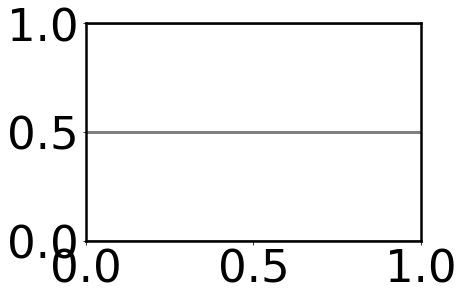

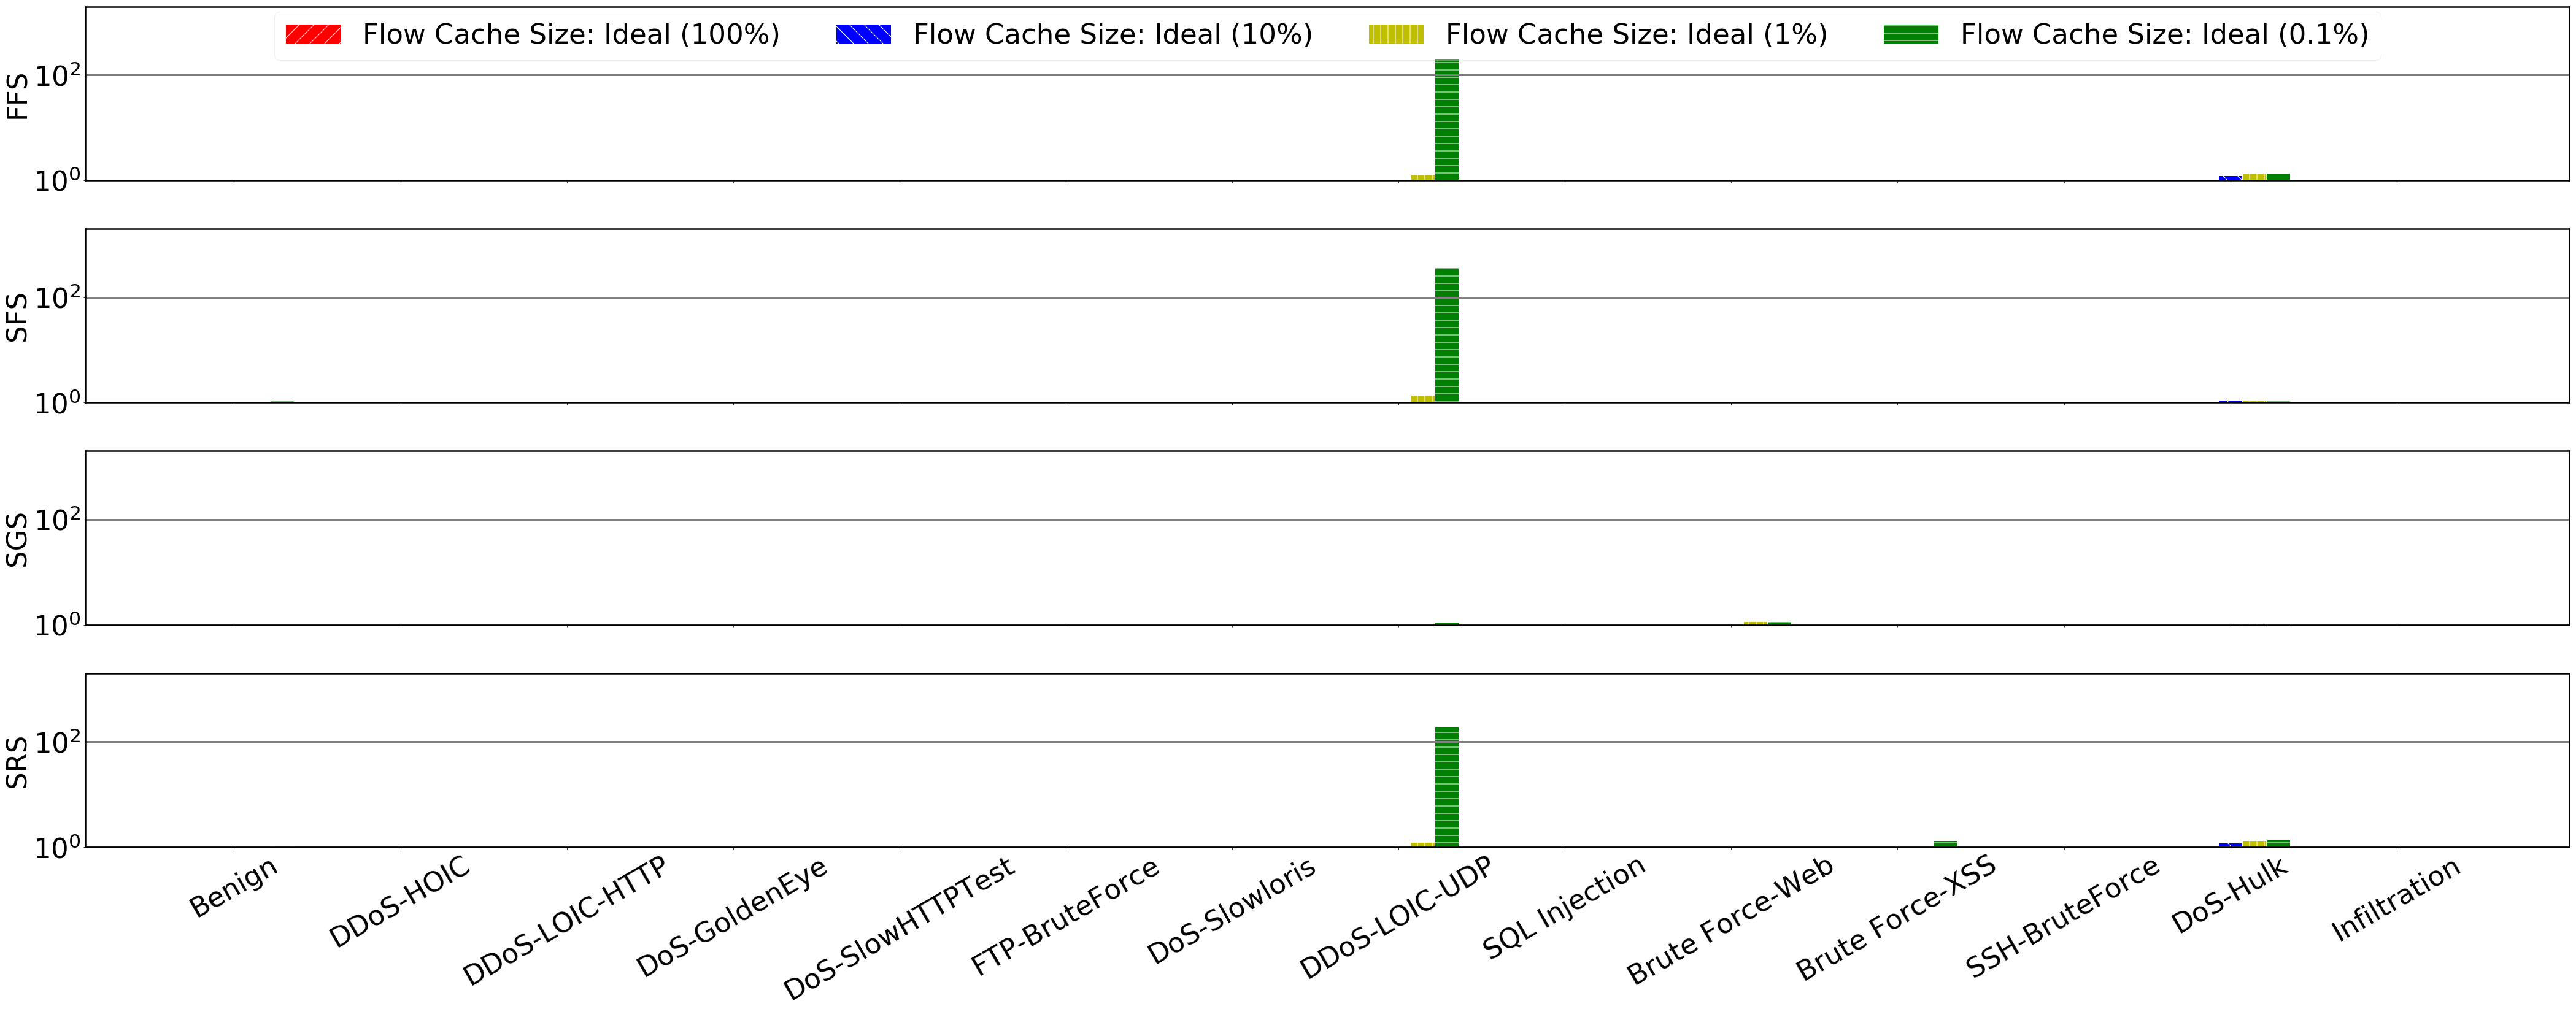

In [17]:
sr_dir = 'SI_1000'
root = '/data/juma/data/ids18/CSVs_r_1.0_m_1.0/{}/'.format(sr_dir) 
draw_figure(root)

saving to  /data/juma/data/ids18/CSVs_r_1.0_m_1.0/SI_100/K_1_RIR_mean.png


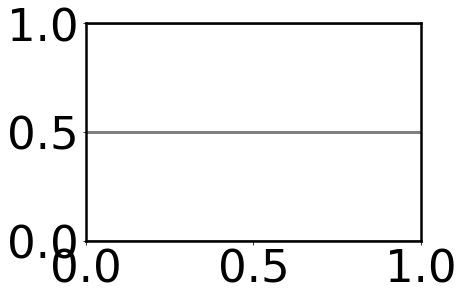

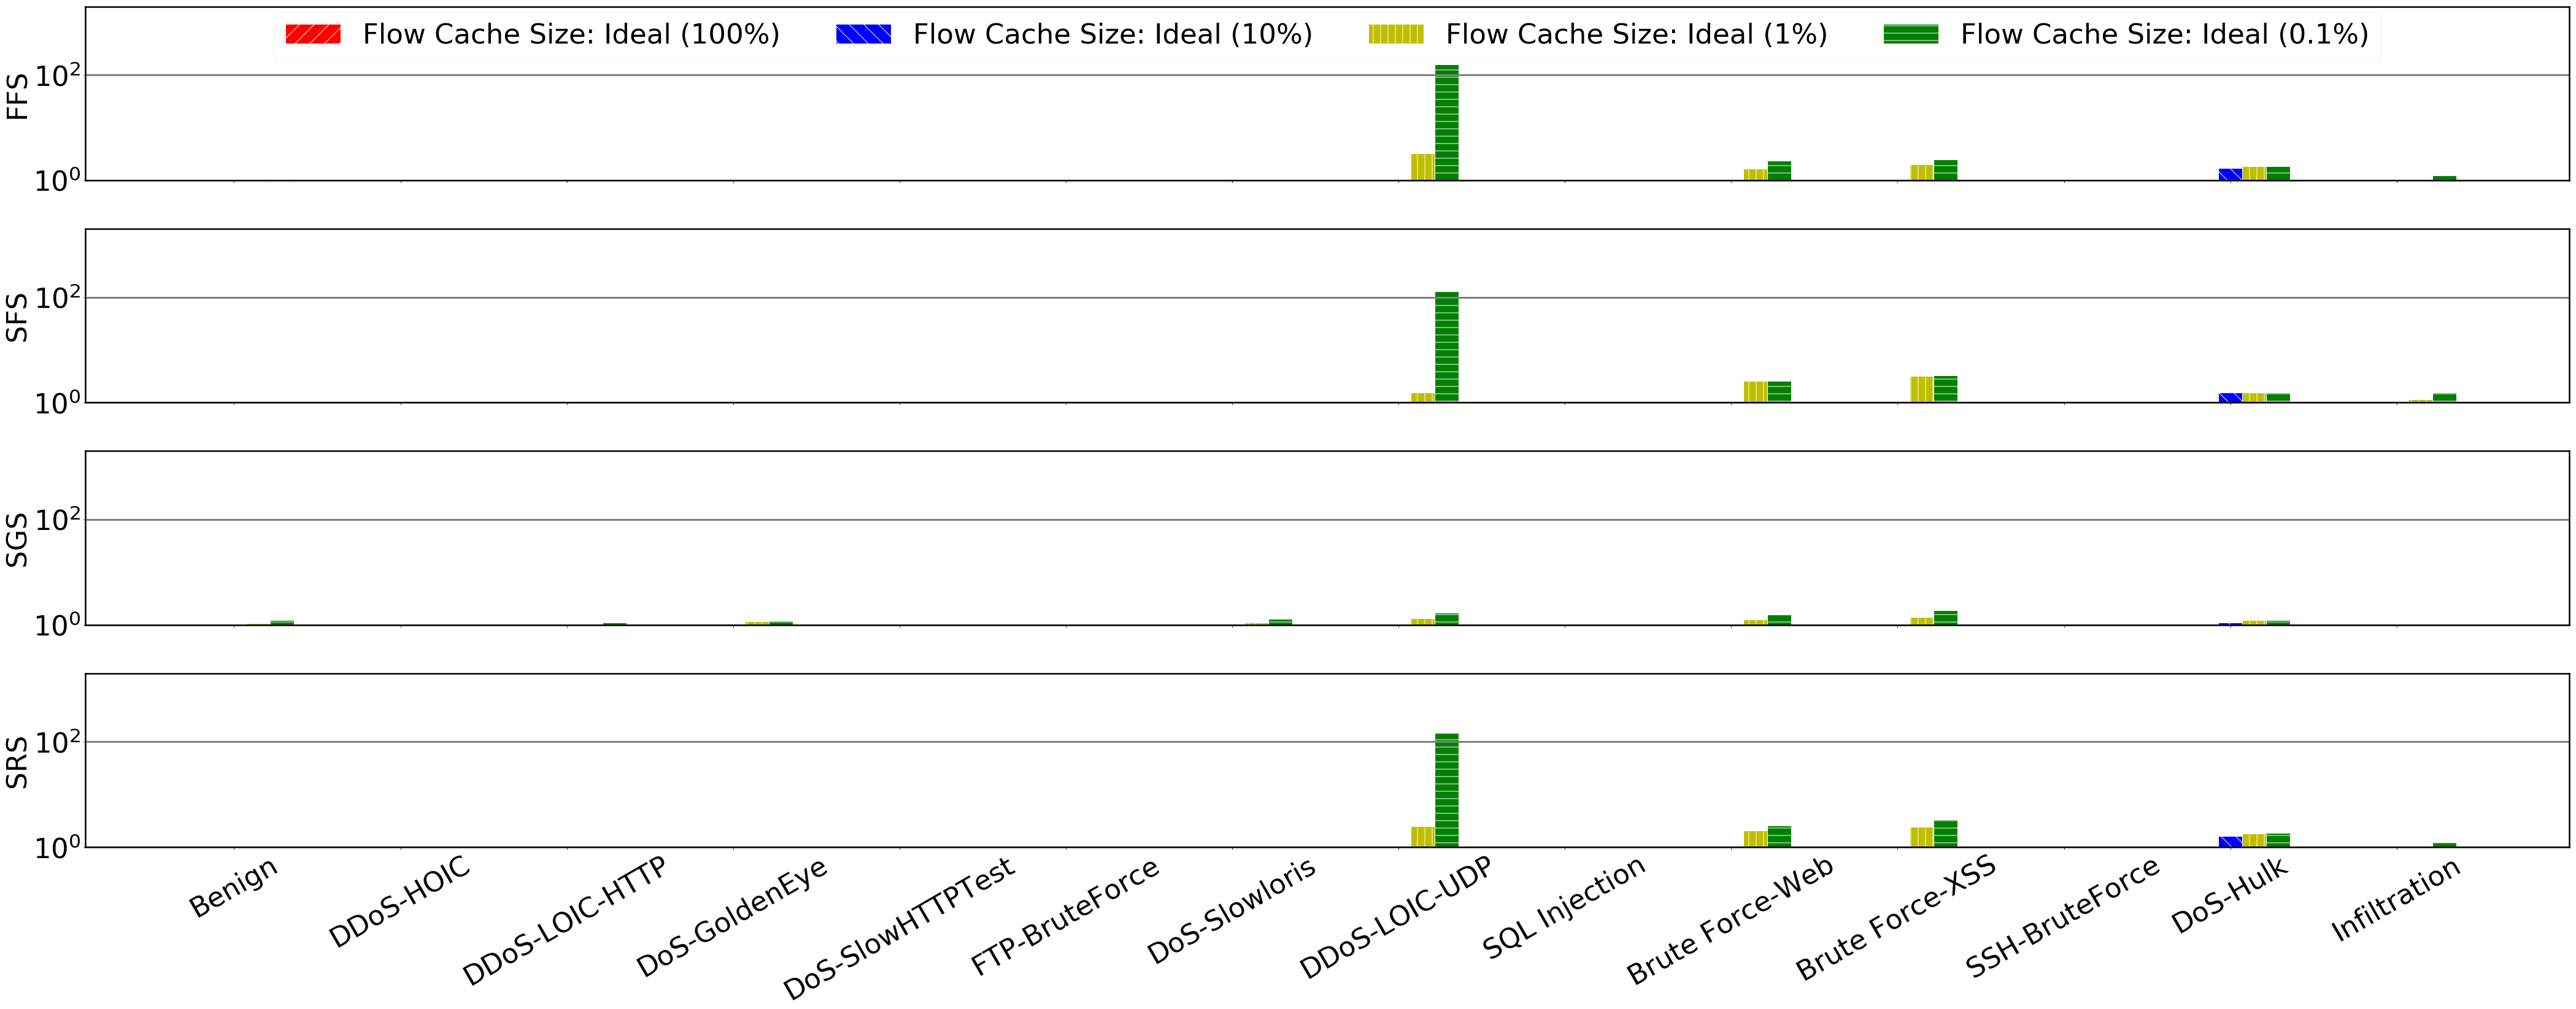

In [18]:
sr_dir = 'SI_100'
root = '/data/juma/data/ids18/CSVs_r_1.0_m_1.0/{}/'.format(sr_dir) 
draw_figure(root)

In [ ]:
sr_dir = 'SR_10.0'
root = '/data/juma/data/ids18/CSVs_r_1.0_m_1.0/{}/'.format(sr_dir) 
draw_figure(root)

saving to  /data/juma/data/ids18/CSVs_r_1.0_m_1.0/K_1_RIR_mean.png


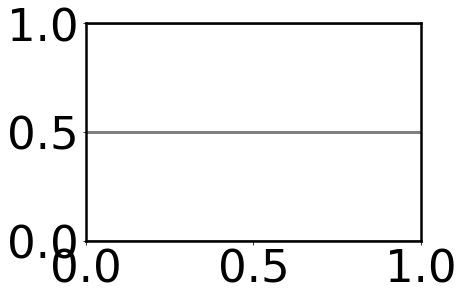

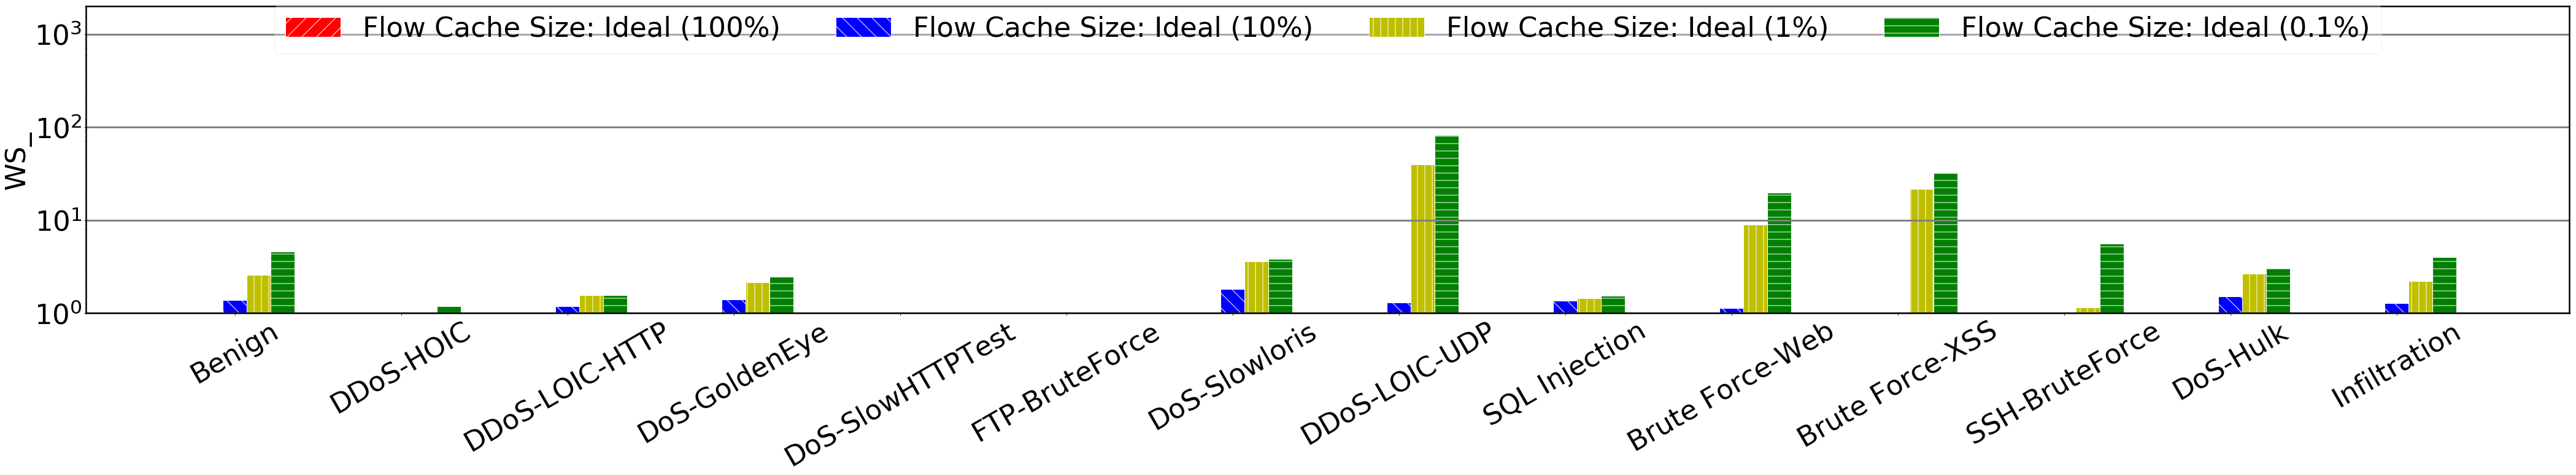

In [19]:
root = '/data/juma/data/ids18/CSVs_r_1.0_m_1.0/'
csv_dirs = ['CSVs_r_1.0_m_1.0', 'CSVs_r_0.1_m_1.0', 'CSVs_r_0.01_m_1.0', 'CSVs_r_0.001_m_1.0']

#drawing
matplotlib_setup()

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(60,12))
plt.xticks([r + barWidth for r in range(len(ordered_labels))] ,ordered_labels,rotation=30)
for i,sampler_dir in enumerate(sorted(glob(join(root,'*_l')))):
    results, ordered_labels = get_increase_rate_mean_avg(sampler_dir)
    sampler_name = ntpath.basename(sampler_dir)

    show_legend = True if i==0 else False
    ylabel='{}'.format(sampler_name[:3])
    plot_bars(ax, results,ylabel=ylabel, xlabel=sampler_name, show_legend=show_legend)


fig.tight_layout()

fn = join(root,OUTFILE)
print('saving to ', fn)
plt.savefig(fn)
    
plt.show()